# Question 3: Trajectory Evaluation and g2o

_Refer to the example notebooks for installation instructions_

# Evo

So you've implemented 2D SLAM, great! Now, what? We need a measure of how good the trajectory is. The error/loss used earlier doesn't tell us much about how the trajectory differs from the ground truth. Here, we try to do just this - compute error metrics. Rather than computing these from scratch, we will just Evo - https://github.com/MichaelGrupp/evo/.

Look at the absolute pose error (APE) and relative pose error (RPE). What do they capture and how are they calculated (descriptive answer)? How do these metrics differ in methodology? Can we determine if the error is more along the x/y axis?

Answer the above questions and report errors for the obtained trajectory.

*Absolute Pose Error(APE) :* This provides the global accuracy of the trajectory by comparing the ground truth and estimated trajectory. We find the rigid body transformation matrix by aligning them both and then we find the error matrices at different time stamps. The mean square error from these matrices we get the APE.
</br>
<img src="../data/APE.png" alt="Drawing" style="width: 250px;"/>
</br>
*Relative Pose Error(RPE) :* RPE gives us the local accuracy of the trajectory with respect to each frame. </br>
We find the relative pose error matrics in a fixed interval of time. The RPE is divided into rotation and translation components. Now, RPE translation error is obtained by the mean squared error of the error matrices whereas the RPE rotation error is by only mean approach.
</br>
<img src="../data/RPE.png" alt="Drawing" style="width: 250px;"/>
</br>
</br>
**->** Yes, we can determine the error whether it is more along x/y axis with the help of "evo_traj"
</br>
<img src="../data/diff_xy.png" alt="Drawing" style="width: 250px;"/>
</br>

In [1]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import jax.numpy as jnp
import jax

In [2]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr]).T
   
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    
    plt.show()
        
def readEdge_odom(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
        if "FIX" in line:
            break

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)) 

def readEdge_lc(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    flag=0
    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "FIX" in line:
            flag=1
        if flag==1:    
            if "EDGE_SE2" in line:
                    (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
                    ind1_arr.append(int(ind1))
                    ind2_arr.append(int(ind2))
                    del_x.append(float(dx))
                    del_y.append(float(dy))
                    del_theta.append(float(dtheta))

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)) 


In [3]:
edges = readEdge_odom("../data/edges.txt")
edges_lc = readEdge_lc("../data/edges.txt")
prior = readVertex("../data/edges.txt")

In [4]:
def pose_estimate(prior, edges):
    [in1_edge,in2_edge,X_edge,Y_edge,Theta_edge] = edges
    X,Y,Theta = [prior[0][0]],[prior[0][1]],[prior[0][2]]
    
    for i in in1_edge:
        delta_X = X_edge[i]
        delta_Y = Y_edge[i]
        
        pose_j = get_pose(X[i], Y[i], Theta[i], delta_X, delta_Y, Theta_edge[i])
        X.append(pose_j[0])
        Y.append(pose_j[1])
        Theta.append(pose_j[2])
        
    return jnp.array([X,Y,Theta]).T

def get_pose(x, y, theta, del_x, del_y, del_theta):
    return jnp.array([x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta), 
                      y + del_x * jnp.sin(theta) + del_y * jnp.cos(theta),
                      theta + del_theta])
def save_g2o_from_edges_init(fromfileName, tofilename, poses):
#     poses = pose_estimate(prior,edges)
    X,Y,Theta = poses[:,0], poses[:,1], poses[:,2]
    f = open(fromfileName, 'r')
    A = f.readlines()
    f.close()
    with open(tofilename, "w") as g2o_file:
        for i,x,y,theta in zip(range(len(X)),X,Y,Theta):
            g2o_file.write("VERTEX_SE2 "+str(i)+" "+str(x)+" "+str(y)+" "+str(theta)+"\n")
        for line in A:
            if "VERTEX_SE2" in line:
                continue
            g2o_file.write(line)  

In [5]:
!cd "../misc";python g2o_to_kitti.py "../data/optimised_traj.g2o"  "../data/optimised_traj.kitti"
!cd "../misc";python g2o_to_kitti.py "../data/gt.g2o"  "../data/gt.kitti"

Figure(640x480)
saved '../data/optimised_traj.kitti' from '../data/optimised_traj.g2o'
Figure(640x480)
saved '../data/gt.kitti' from '../data/gt.g2o'


In [16]:
!evo_rpe kitti "../data/gt.kitti" "../data/optimised_traj.kitti" -v --plot --plot_mode xz

--------------------------------------------------------------------------------
Loaded 120 poses from: ../data/gt.kitti
Loaded 120 poses from: ../data/optimised_traj.kitti
--------------------------------------------------------------------------------
Found 119 pairs with delta 1 (frames) among 120 poses using consecutive pairs.
Compared 119 relative pose pairs, delta = 1 (frames) with consecutive pairs.
Calculating RPE for translation part pose relation...
--------------------------------------------------------------------------------
RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.361127
      mean	0.127821
    median	0.121930
       min	0.005519
      rmse	0.145925
       sse	2.534000
       std	0.070398

--------------------------------------------------------------------------------
Plotting results... 


In [7]:
!evo_rpe kitti "../data/gt.kitti" "../data/optimised_traj.kitti" -v --plot --plot_mode xy

--------------------------------------------------------------------------------
Loaded 120 poses from: ../data/gt.kitti
Loaded 120 poses from: ../data/optimised_traj.kitti
--------------------------------------------------------------------------------
Found 119 pairs with delta 1 (frames) among 120 poses using consecutive pairs.
Compared 119 relative pose pairs, delta = 1 (frames) with consecutive pairs.
Calculating RPE for translation part pose relation...
--------------------------------------------------------------------------------
RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.361127
      mean	0.127821
    median	0.121930
       min	0.005519
      rmse	0.145925
       sse	2.534000
       std	0.070398

--------------------------------------------------------------------------------
Plotting results... 


In [8]:
!evo_ape kitti "../data/gt.kitti" "../data/optimised_traj.kitti" -v --plot --plot_mode xy

--------------------------------------------------------------------------------
Loaded 120 poses from: ../data/gt.kitti
Loaded 120 poses from: ../data/optimised_traj.kitti
--------------------------------------------------------------------------------
Compared 120 absolute pose pairs.
Calculating APE for translation part pose relation...
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(not aligned)

       max	5.279695
      mean	2.093739
    median	1.722805
       min	0.000000
      rmse	2.641265
       sse	837.153781
       std	1.610137

--------------------------------------------------------------------------------
Plotting results... 


In [2]:
!evo_traj kitti "../data/gt.kitti" "../data/optimised_traj.kitti" -v --plot --plot_mode xy

--------------------------------------------------------------------------------
Loaded 120 poses from: ../data/gt.kitti
Loaded 120 poses from: ../data/optimised_traj.kitti
--------------------------------------------------------------------------------
name:	gt
infos:
	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
name:	optimised_traj
infos:
	nr. of poses	120
	path length (m)	53.99272531638332
	pos_end (m)	[-6.9523926 -3.3227053  0.       ]
	pos_start (m)	[-8.  5.  0.]


If you're interested, play around with this tool and add any other plots that you think might be relevant/interesting.

# g2o

Install g2o as mentioned in `examples/g2o.ipynb` and optimise `edges.txt`, the file you used earlier. Also use `g2o_viewer` and optimize `intel` (a trajectory in the Intel research lab) and `sphere`. They should look something like:


<table><tr>
<td> <img src="../misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="../misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Write briefly about your observations and try out few options in the GUI. What do they do, how do they perform?

In [10]:
!g2o -o "../data/optmised.g2o" "../data/edges-poses.g2o"

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from ../data/edges-poses.g2o
Loaded 120 vertices
Loaded 139 edges
# graph is fixed by priors or already fixed vertex
Initial chi2 = 573824.347294
saving ../data/optmised.g2o ... done.


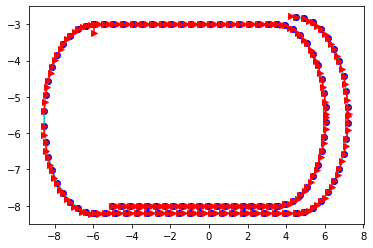

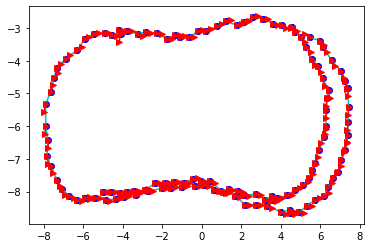

In [11]:
g2o_optimised = readVertex("../data/optmised.g2o")
poses_gt = readVertex("../data/gt.txt")
draw(poses_gt[:,0], poses_gt[:,1], poses_gt[:,2])
draw(g2o_optimised[:, 0], g2o_optimised[:, 1], g2o_optimised[:, 2]) #error only at x

In [12]:
!g2o_viewer "../data/edges-poses.g2o"


The constructor with a shareWidget is deprecated, use the regular contructor instead.


<img src="../data/edges_poses.jpeg" alt="Drawing"/>




In [13]:
!g2o_viewer "../data/intel.g2o"

The constructor with a shareWidget is deprecated, use the regular contructor instead.


<img src="../data/intel.jpeg" alt="Drawing"/>

In [14]:
!g2o_viewer "../data/sphere.g2o"

The constructor with a shareWidget is deprecated, use the regular contructor instead.


<img src="../data/sphere.jpeg" alt="Drawing"/>

These are some of the observations for different optimisers:

1. ***gn_var_cholmod, gn_fix3_2_cholmod, dl_var*** worked properly for optimisations.
2. ***gn_dense, lm_dense*** stalled the system, everything got stuck
3. ***gn_var, gn_var_csparse*** didn't worked
4. nothing changed in case of ***structure_only_2***
5. "preparing (no marginalisation of landmarks)" got this output for ***gn dense/lm_dense***
